# Project requirement 3

## Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt

## Generating demand curves

In [2]:
def generate_demand_curve(epoch, interval, max_intervals, seed):
    np.random.seed(seed)
    num_changes = np.random.randint(0, 3)  # 0 to 2 changes
    change_points = np.sort(np.random.randint(0, max_intervals, size=num_changes))
    
    segment = np.sum(interval >= change_points)
    
    np.random.seed(seed + epoch + segment)
    a_values = [np.random.uniform(0.5, 0.8) for _ in range(num_changes + 1)]  # Intercept between 0.5 and 1.0
    b_values = [np.random.uniform(0.2, 0.6) for _ in range(num_changes + 1)]  # Slope between 0.1 and 1.0
    
    a = a_values[segment]
    b = b_values[segment]
    
    def demand_curve(p):
        if p > 1:
            return 0
        return max(0, a - b * p)
    
    return demand_curve

## Function for the computation of clairvoyant revenue

In [3]:
def compute_clairvoyant_revenue(demand_curve, price_points, cost_per_unit):
    best_revenue = 0
    best_price = None
    for price in price_points:
        demand = demand_curve(price)
        revenue = (price - cost_per_unit) * demand
        if revenue > best_revenue:
            best_revenue = revenue
            best_price = price
    return best_price, best_revenue * 100  # Scaling the best revenue by 100


## Sliding Window UCB Pricing Agent

In [4]:
class SWUCBPricingAgent:
    def __init__(self, price_points, K, T=1000, W=23, range=1):
        self.price_points = price_points
        self.W = W
        self.K = len(price_points)
        self.T = T
        self.range = range
        self.p_t = None
        self.cache = np.repeat(np.nan, repeats=K*W).reshape(W, K)
        self.N_picks = np.zeros(K)
        self.t = 0

    def choose_price(self):
        if self.t < self.K:
            self.p_t = self.t
        else:
            n_pulls_last_w = self.W - np.isnan(self.cache).sum(axis=0)
            if np.all(np.isnan(self.cache)):
                ucbs = np.inf * np.ones(self.K)  # Encourage exploration if cache is empty
            else:
                avg_last_w = np.nanmean(self.cache, axis=0)
                valid_pulls = n_pulls_last_w > 0  # Ensure there are valid pulls
                ucbs = np.zeros_like(avg_last_w)
                ucbs[valid_pulls] = avg_last_w[valid_pulls] + self.range * np.sqrt(2 * np.log(self.W) / n_pulls_last_w[valid_pulls])
                ucbs[~valid_pulls] = np.inf  # Encourage exploration for arms with no valid pulls
            self.p_t = np.argmax(ucbs)
        chosen_price = self.price_points[self.p_t]
        return chosen_price
        
    def update(self, r_t):
        self.N_picks[self.p_t] += 1
        self.cache = np.delete(self.cache, (0), axis=0)  # remove oldest observation
        new_samples = np.repeat(np.nan, self.K)
        new_samples[self.p_t] = r_t
        self.cache = np.vstack((self.cache, new_samples))  # add new observation
        self.t += 1

    def simulate_demand(self, demand_function, price, noise_level=0.1, seed=None):
        if seed is not None:
            np.random.seed(seed)
        mean_demand = demand_function(price)
        return np.clip(np.random.normal(mean_demand, noise_level), 0, 1)  # Ensuring demand is between 0 and 1

## Running the algorithm and calculating results

In [5]:
# Initialize agent and parameters
price_points = np.linspace(0.1, 0.9, 8)  # Prices between 0 and 1
cost_per_unit = 0.1

# Define number of trials and intervals
num_trials = 5
num_intervals = 10500
window_size = int(2 * np.sqrt(num_intervals * np.log(num_intervals) / 2))

# Create a fixed array of seeds to make sure the noises get the same values at each run
np.random.seed(24)
seeds = np.random.randint(1, 501, size=num_intervals)

# Create a fixed array of seeds for epochs to ensure the demand curves change at different times each epoch
epoch_seeds = np.random.randint(1, 1001, size=num_trials)

# Initialize storage for cumulative regrets and revenues of all trials
all_cumulative_regrets = np.zeros((num_trials, num_intervals))
all_agent_revenues = np.zeros((num_trials, num_intervals))
all_clairvoyant_revenues = np.zeros((num_trials, num_intervals))

for trial in range(num_trials):
    agent = SWUCBPricingAgent(price_points, len(price_points), T=num_intervals, W=window_size, range=1)
    cumulative_regrets = []
    agent_revenues = []
    clairvoyant_revenues = []

    for interval in range(num_intervals):
        demand_curve = generate_demand_curve(trial, interval, num_intervals, epoch_seeds[trial])
        best_price, best_revenue = compute_clairvoyant_revenue(demand_curve, price_points, cost_per_unit)
        chosen_price = agent.choose_price()
        actual_demand = agent.simulate_demand(demand_curve, chosen_price, seed=seeds[interval])
        agent_revenue = (chosen_price - cost_per_unit) * np.random.binomial(100, actual_demand)

        agent.update(agent_revenue)
        
        # Store revenues and compute cumulative regret
        agent_revenues.append(agent_revenue)
        clairvoyant_revenues.append(best_revenue)
        regret = best_revenue - agent_revenue
        cumulative_regrets.append(regret if interval == 0 else cumulative_regrets[-1] + regret)

    # Store trial data
    all_cumulative_regrets[trial] = cumulative_regrets
    all_agent_revenues[trial] = agent_revenues
    all_clairvoyant_revenues[trial] = clairvoyant_revenues

# Compute average and standard deviation of cumulative regrets and average revenues across trials
average_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
std_dev_cumulative_regret = np.std(all_cumulative_regrets, axis=0)
average_agent_revenues = np.mean(all_agent_revenues, axis=0)
average_clairvoyant_revenues = np.mean(all_clairvoyant_revenues, axis=0)



## Plotting the results

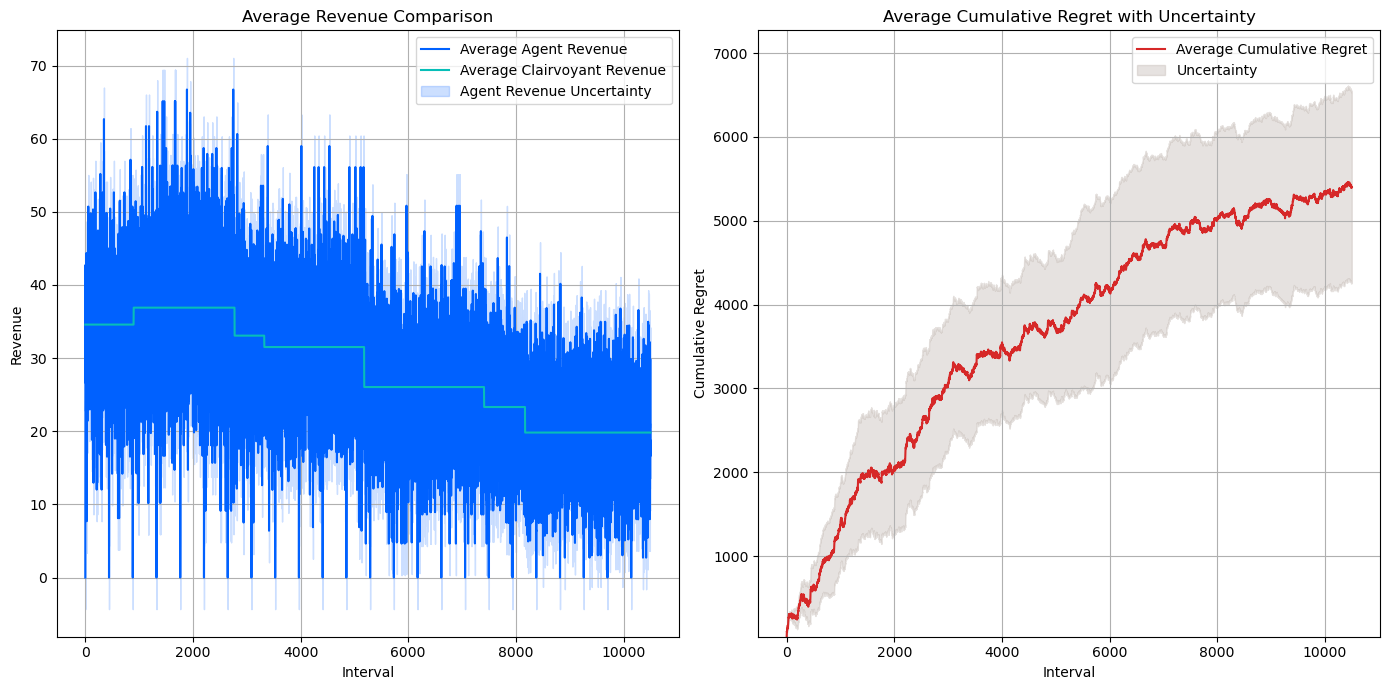

In [6]:
plt.figure(figsize=(14, 7))

# Plot for revenues
plt.subplot(1, 2, 1)
plt.plot(average_agent_revenues, label='Average Agent Revenue', color='#0061ff')
plt.plot(average_clairvoyant_revenues, label='Average Clairvoyant Revenue', color='#07BEB8')
plt.fill_between(range(num_intervals),
                 average_agent_revenues - np.std(average_agent_revenues) / np.sqrt(num_trials),
                 average_agent_revenues + np.std(average_agent_revenues) / np.sqrt(num_trials),
                 alpha=0.2, color='#0061ff', label='Agent Revenue Uncertainty')
plt.title('Average Revenue Comparison')
plt.xlabel('Interval')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Plot for cumulative regret
plt.subplot(1, 2, 2)
plt.plot(average_cumulative_regret, label='Average Cumulative Regret', color='#d62828')
plt.fill_between(range(num_intervals),
                 average_cumulative_regret - std_dev_cumulative_regret / np.sqrt(num_trials),
                 average_cumulative_regret + std_dev_cumulative_regret / np.sqrt(num_trials),
                 alpha=0.4, color='#C2B8B2', label='Uncertainty')
plt.ylim([min(average_cumulative_regret - std_dev_cumulative_regret / np.sqrt(num_trials)) * 1.1,
          max(average_cumulative_regret + std_dev_cumulative_regret / np.sqrt(num_trials)) * 1.1])
plt.title('Average Cumulative Regret with Uncertainty')
plt.xlabel('Interval')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


## CUSUM Pricing Agent

In [7]:
class CUSUMPricingAgent:
    def __init__(self, price_points, M, h, K=len(price_points), T=1000, alpha=0.99, range=1):
        self.price_points = price_points
        self.K = len(price_points)
        self.T = T
        self.M = M
        self.h = h
        self.alpha=alpha
        self.range = range
        self.p_t = None
        self.reset_times = np.zeros(K)
        self.N_pulls = np.zeros(K)
        self.all_rewards = [[] for _ in np.arange(K)]
        self.counters = np.repeat(M, K)
        self.average_rewards = np.zeros(K)
        self.n_resets = np.zeros(K)
        self.n_t = 0
        self.t = 0

    def choose_price(self):
        if (self.counters > 0).any():
            for p in np.arange(self.K):
                if self.counters[p] > 0:
                    self.counters[p] -= 1
                    self.p_t = p
                    break
        else:
            if np.random.random() <= 1-self.alpha:
                ucbs = self.average_rewards + self.range*np.sqrt(np.log(self.n_t)/self.N_pulls)
                self.p_t = np.argmax(ucbs)
            else:
                self.p_t = np.random.choice(np.arange(self.K)) # extra explorationbs)
        chosen_price = self.price_points[self.p_t]
    
        return chosen_price
        
    def update(self, r_t):
        self.N_pulls[self.p_t] += 1
        self.all_rewards[self.p_t].append(r_t)
        if self.counters[self.p_t] == 0:
            if self.change_detection():
                self.n_resets[self.p_t] +=1 
                self.N_pulls[self.p_t] = 0
                self.average_rewards[self.p_t] = 0
                self.counters[self.p_t] = self.M
                self.all_rewards[self.p_t] = []
                self.reset_times[self.p_t] = self.t 
            else:
                self.average_rewards[self.p_t] += (r_t - self.average_rewards[self.p_t])/self.N_pulls[self.p_t]
        self.n_t = sum(self.N_pulls)
        self.t += 1
        
    def change_detection(self):
        ''' CUSUM CD sub-routine. This function returns 1 if there's evidence that the last pulled arm has its average reward changed '''
        u_0 = np.mean(self.all_rewards[self.p_t][:self.M])
        sp, sm = (np.array(self.all_rewards[self.p_t][self.M:])- u_0, u_0 - np.array(self.all_rewards[self.p_t][self.M:]))
        gp, gm = 0, 0
        for sp_, sm_ in zip(sp, sm):
            gp, gm = max([0, gp + sp_]), max([0, gm + sm_])
            if max([gp, gm]) >= self.h:
                return True
        return False
    
    def simulate_demand(self, demand_function, price, noise_level=0.1, seed=None):
        if seed is not None:
            np.random.seed(seed)
        mean_demand = demand_function(price)
        return np.maximum(0, np.random.normal(mean_demand, noise_level))

## Running the algorithm and calculating results

In [8]:
# Initialize agent and parameters
price_points = np.linspace(0.1, 0.9, 8)  # Prices between 0 and 1
cost_per_unit = 0.1

# Define number of trials and intervals
num_trials = 6
num_intervals = 10500
T = num_intervals
h = 2*np.log(T/2) # sensitivity of detection, threshold for cumulative deviation
alpha = np.sqrt(2*np.log(T/2)/T) # probability of extra exploration

M = int(np.log(T/2)) # robustness of change detection


# Create a fixed array of seeds to make sure the noises get the same values at each run
np.random.seed(24)
seeds = np.random.randint(1, 501, size=num_intervals)

# Create a fixed array of seeds for epochs to ensure the demand curves change at different times each epoch
epoch_seeds = np.random.randint(1, 1001, size=num_trials)

# Initialize storage for cumulative regrets and revenues of all trials
all_cumulative_regrets = np.zeros((num_trials, num_intervals))
all_agent_revenues = np.zeros((num_trials, num_intervals))
all_clairvoyant_revenues = np.zeros((num_trials, num_intervals))

for trial in range(num_trials):
    agent = CUSUMPricingAgent(price_points, M, h, T=num_intervals, range=1)
    cumulative_regrets = []
    agent_revenues = []
    clairvoyant_revenues = []

    for interval in range(num_intervals):
        demand_curve = generate_demand_curve(trial, interval, num_intervals, epoch_seeds[trial])
        best_price, best_revenue = compute_clairvoyant_revenue(demand_curve, price_points, cost_per_unit)
        chosen_price = agent.choose_price()
        actual_demand = agent.simulate_demand(demand_curve, chosen_price, seed=seeds[interval])
        agent_revenue = (chosen_price - cost_per_unit) * np.random.binomial(100, actual_demand)

        agent.update(agent_revenue)
        
        # Store revenues and compute cumulative regret
        agent_revenues.append(agent_revenue)
        clairvoyant_revenues.append(best_revenue)
        regret = best_revenue - agent_revenue
        cumulative_regrets.append(regret if interval == 0 else cumulative_regrets[-1] + regret)

    # Store trial data
    all_cumulative_regrets[trial] = cumulative_regrets
    all_agent_revenues[trial] = agent_revenues
    all_clairvoyant_revenues[trial] = clairvoyant_revenues

# Compute average and standard deviation of cumulative regrets and average revenues across trials
average_cumulative_regret = np.mean(all_cumulative_regrets, axis=0)
std_dev_cumulative_regret = np.std(all_cumulative_regrets, axis=0)
average_agent_revenues = np.mean(all_agent_revenues, axis=0)
average_clairvoyant_revenues = np.mean(all_clairvoyant_revenues, axis=0)


## Plotting the results

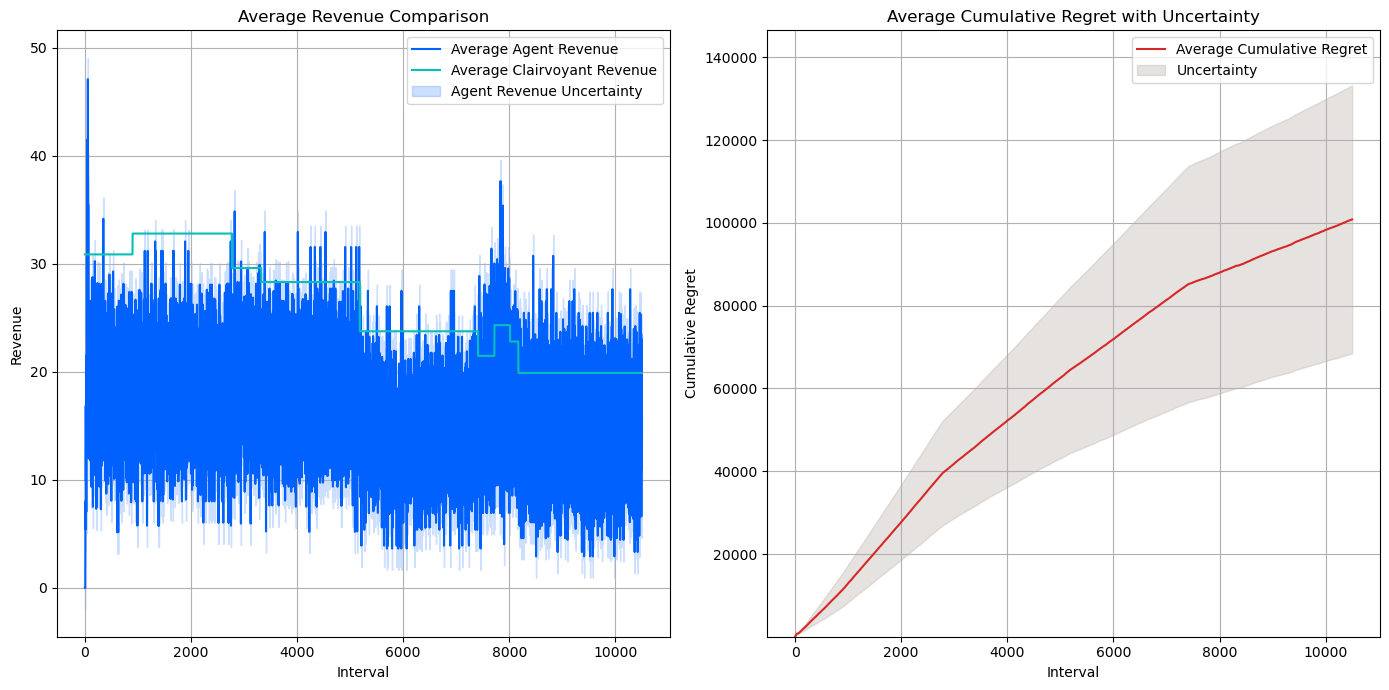

In [9]:
plt.figure(figsize=(14, 7))

# Plot for revenues
plt.subplot(1, 2, 1)
plt.plot(average_agent_revenues, label='Average Agent Revenue', color='#0061ff')
plt.plot(average_clairvoyant_revenues, label='Average Clairvoyant Revenue', color='#07BEB8')
plt.fill_between(range(num_intervals),
                 average_agent_revenues - np.std(average_agent_revenues) / np.sqrt(num_trials),
                 average_agent_revenues + np.std(average_agent_revenues) / np.sqrt(num_trials),
                 alpha=0.2, color='#0061ff', label='Agent Revenue Uncertainty')
plt.title('Average Revenue Comparison')
plt.xlabel('Interval')
plt.ylabel('Revenue')
plt.legend()
plt.grid(True)

# Plot for cumulative regret
plt.subplot(1, 2, 2)
plt.plot(average_cumulative_regret, label='Average Cumulative Regret', color='#d62828')
plt.fill_between(range(num_intervals),
                 average_cumulative_regret - std_dev_cumulative_regret / np.sqrt(num_trials),
                 average_cumulative_regret + std_dev_cumulative_regret / np.sqrt(num_trials),
                 alpha=0.4, color='#C2B8B2', label='Uncertainty')
plt.ylim([min(average_cumulative_regret - std_dev_cumulative_regret / np.sqrt(num_trials)) * 1.1,
          max(average_cumulative_regret + std_dev_cumulative_regret / np.sqrt(num_trials)) * 1.1])
plt.title('Average Cumulative Regret with Uncertainty')
plt.xlabel('Interval')
plt.ylabel('Cumulative Regret')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()
